# Initialization

In [ ]:
! pip install nba_api pytrends unidecode kagglehub[pandas-datasets]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import requests
import time
import os
import re
import random
from datetime import datetime, timedelta
from tqdm import tqdm
import json
from collections import defaultdict
import unidecode

from nba_api.stats.static import teams
from nba_api.stats.endpoints import PlayerGameLogs, scheduleleaguev2, leaguedashplayerstats

import kagglehub
from kagglehub import KaggleDatasetAdapter

from pytrends.request import TrendReq

from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
tqdm.pandas()

ModuleNotFoundError: No module named 'unidecode'

# Update your Google Drive Path here

In [ ]:
gdrive_path = '/content/drive/My Drive/SIADS 593: Milestone 1/Team Project Analysis'

# Function Definitions

## Common Functions

In [ ]:
def clean_invisible(df):

    invisible_chars = ['\u200b', '\ufeff', '\u2060', '\u00a0', '\t', '\r', '\n']

    # Remove invisible characters from all cells
    df = df.replace(invisible_chars, '', regex=True)

    # Strip whitespace from string columns
    str_cols = df.select_dtypes(include='object').columns
    df[str_cols] = df[str_cols].apply(lambda col: col.str.strip())

    # Replace empty strings with NaN and infer better dtypes
    df = df.replace('', np.nan).infer_objects(copy=False)

    return df

In [ ]:
def rename_season_string(s):
    """
    Converts strings like '2022/2023' to '2022-23'.
    If no match is found, returns the original string.
    """
    match = re.match(r'^(\d{4})/(\d{4})$', s)
    if match:
        start_year = match.group(1)
        end_year_short = match.group(2)[-2:]
        return f"{start_year}-{end_year_short}"
    return s

In [ ]:
def parse_season_year(season_str):
    start_year = int(season_str.split('-')[0])
    end_year = start_year + 1
    return f"{start_year}-10-01 {end_year}-06-30"

In [ ]:
def batch_dict(input_dict, size=5):
    items = list(input_dict.items())
    return [dict(items[i:i+size]) for i in range(0, len(items), size)]

## NBA API Functions

In [ ]:
def get_recent_seasons(n_full_seasons=3):
    now = datetime.now()
    year = now.year
    month = now.month

    # Determine the current or most recent season's starting year
    if month < 7:
        current_season_start_year = year - 1
    else:
        current_season_start_year = year

    # Generate N full seasons before, plus the current/recent one
    seasons = [
        f"{y}-{str(y + 1)[-2:]}" for y in range(current_season_start_year - n_full_seasons, current_season_start_year + 1
                                                )
    ]

    return seasons

seasons = get_recent_seasons(4)
print(seasons)

['2020-21', '2021-22', '2022-23', '2023-24', '2024-25']


In [ ]:
def get_season_weeks(season=None):
    if season is None:
        season = seasons[-1]

    schedule = scheduleleaguev2.ScheduleLeagueV2(season=season, league_id='00') # League ID = '00' is NBA
    schedule_df = schedule.get_data_frames()[1]
    schedule_df = schedule_df.sort_values(by='weekNumber', ascending=True)

    datetime_cols = ['startDate', 'endDate']
    for col in datetime_cols:
        schedule_df[col] = pd.to_datetime(schedule_df[col])

    return schedule_df

In [ ]:
def get_season_games(season=None):
    if season is None:
        season = seasons[-1]

    schedule = scheduleleaguev2.ScheduleLeagueV2(season=season, league_id='00') # League ID = '00' is NBA
    schedule_df = schedule.get_data_frames()[0]
    return schedule_df

## Kaggle API Functions

In [ ]:
def get_kaggle_credentials(file_path):
    try:
        with open(file_path, 'r') as f:
            kaggle_credentials = json.load(f)

        if 'username' in kaggle_credentials and 'key' in kaggle_credentials:
            print("Kaggle credentials loaded successfully.")
            return kaggle_credentials
        else:
            print("Warning: Missing expected keys in kaggle.json")
            print("Found keys:", kaggle_credentials.keys())
            return None

    except FileNotFoundError:
        print(f"Error: The file was not found at {file_path}")
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from the file at {file_path}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

    return None

In [ ]:
def kaggle_login(file_path=os.path.join(gdrive_path, "kaggle.json")):
    creds = get_kaggle_credentials(file_path)
    if creds:
        os.environ['KAGGLE_USERNAME'] = creds['username']
        os.environ['KAGGLE_KEY'] = creds['key']
        print("Environment variables set for Kaggle API.")
        return True
    else:
        print("Could not set Kaggle API credentials.")
        return False

In [ ]:
def get_kaggle_dataset(dataset_path, file_path):
    df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, dataset_path, file_path)
    return df

## Google Trends API Functions

In [ ]:
# Chris R - Screenshot for report | DELETE BEFORE SUBMITTING
from pytrends.request import TrendReq

proxies = ['https://34.203.233.13:80','https://35.201.123.31:880']

pytrends = TrendReq(hl='en-US'
                    , tz=360
                    , timeout=(10,25)
                    , proxies=proxies

                    )

In [ ]:
proxies = ['https://34.203.233.13:80','https://35.201.123.31:880']

pytrends = TrendReq(hl='en-US'
                    , tz=360
                    , timeout=(10,25)
                    # , proxies=proxies
                    # , retries=2
                    # , backoff_factor=0.1
                    # , requests_args={'verify':False}
                    )

In [ ]:
def get_topic_id(keyword):
    try:
        suggestions_json = pytrends.suggestions(keyword)
        suggestions_df = pd.DataFrame(suggestions_json)
        topic_id = suggestions_df['mid'].values[0]
        return topic_id
    except Exception:
        return None

In [ ]:
def build_keyword_dict(df):
    keyword_dict = {}
    pytrends = TrendReq(hl='en-US', tz=360)

    # intent is to collect all (team, player) with season timeframes
    combo_timeframes = defaultdict(list)

    for _, row in df.iterrows():
        season = row['seasonYear']
        team = row['teamName']
        player = row['PLAYER_NAME']

        if pd.notnull(player):
            timeframe = parse_season_year(season)
            combo_timeframes[(team, player)].append((season, timeframe))

    # Collapse timeframes and get topic IDs
    for (team, player), season_ranges in combo_timeframes.items():
        try:
            # Get topic ID
            suggestions = pytrends.suggestions(player)
            suggestions_df = pd.DataFrame(suggestions)
            topic_id = suggestions_df['mid'].values[0]
        except Exception:
            print(f"Skipping {player} — no topic ID found")
            continue

        # Combine timeframes to minimize api requests
        start_dates = [tf.split()[0] for _, tf in season_ranges]
        end_dates = [tf.split()[1] for _, tf in season_ranges]
        merged_timeframe = f"{min(start_dates)} {max(end_dates)}"
        seasons = sorted(set([s for s, _ in season_ranges]))

        keyword_dict[(team, player)] = {
            'topic_id': topic_id,
            'timeframe': merged_timeframe,
            'seasons': seasons
        }

        time.sleep(np.random.rand())

    return keyword_dict

In [ ]:
def fetch_trends_by_season_team(keyword_dict, retries=2):
    all_interest_dfs = []

    for (season, team), content in keyword_dict.items():
        kw_map = content['keywords']
        timeframe = content['timeframe']

        for batch in batch_dict(kw_map, size=5):
            print(f"Fetching for {season} - {team}: {list(batch.keys())}")
            attempt = 0
            while attempt <= retries:
                try:
                    pytrends.build_payload(
                        kw_list=list(batch.values()),  # topic IDs
                        cat=264,
                        timeframe=timeframe,
                        geo='US',
                        gprop=''
                    )
                    df = pytrends.interest_over_time()
                    if not df.empty:
                        df = df.drop(columns=['isPartial'], errors='ignore')
                        df.columns = [k for k in batch.keys()]
                        df['season'] = season
                        df['team'] = team
                        all_interest_dfs.append(df)
                        print("Success")
                    break
                except Exception as e:
                    wait = 1.5 * (2 ** attempt)
                    print(f"Attempt {attempt+1} failed: {e} — retrying in {wait:.1f}s")
                    time.sleep(wait)
                    attempt += 1

            time.sleep(np.random.rand())

    if all_interest_dfs:
        combined_df = pd.concat(all_interest_dfs, axis=0)
        combined_df.reset_index(inplace=True)
        return combined_df
    else:
        print("No data collected.")
        return pd.DataFrame()

In [ ]:
keyword_dict_path = os.path.join(gdrive_path, "keyword_dict.json")

def save_keyword_dict(data, path=keyword_dict_path):
    serializable_data = {
        f"{season}|||{team}": content
        for (season, team), content in data.items()
    }
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(serializable_data, f, indent=2)

In [ ]:
def load_keyword_dict(path=keyword_dict_path):
    if os.path.exists(path):
        with open(path, 'r', encoding='utf-8') as f:
            raw_data = json.load(f)
            return {
                tuple(k.split("|||")): v
                for k, v in raw_data.items()
            }
    return None

In [ ]:
trends_pickle_path = os.path.join(gdrive_path, 'player_trends_df.pkl')

def load_existing_interest_data(path=trends_pickle_path):
    if os.path.exists(path):
        return pd.read_pickle(path)
    else:
        return pd.DataFrame()

def append_to_pickle(df, path=trends_pickle_path):
    if os.path.exists(path):
        existing = pd.read_pickle(path)
        combined = pd.concat([existing, df], ignore_index=True)
    else:
        combined = df
    combined.to_pickle(path)

In [ ]:
def fetch_trends_by_topic(keyword_dict, pickle_path=trends_pickle_path, retries=2):
    pytrends = TrendReq(hl='en-US', tz=360)
    existing_df = load_existing_interest_data(pickle_path)
    players_collected = set(existing_df.columns[1:]) if not existing_df.empty else set()  # exclude 'date'

    result_df = existing_df if not existing_df.empty else pd.DataFrame()

    for (team, player), content in keyword_dict.items():
        if player in players_collected:
            print(f"Skipping {player}, already collected.")
            continue

        topic_id = content['topic_id']
        timeframe = content['timeframe']
        print(f"Fetching for {team} - {player}: {topic_id} | {timeframe}")

        attempt = 0
        while attempt <= retries:
            try:
                pytrends.build_payload([topic_id], cat=264, timeframe=timeframe, geo='US', gprop='')
                df = pytrends.interest_over_time()
                if not df.empty:
                    df = df.drop(columns=['isPartial'], errors='ignore')
                    df.reset_index(inplace=True)
                    df.rename(columns={topic_id: player}, inplace=True)

                    if result_df.empty:
                        result_df = df[['date', player]]
                    else:
                        result_df = pd.merge(result_df, df[['date', player]], on='date', how='outer')

                    result_df.to_pickle(pickle_path)
                    print(" - Success and merged.")
                break
            except Exception as e:
                wait = 1.5 * (2 ** attempt)
                print(f" - Attempt {attempt+1} failed: {e} — retrying in {wait:.1f}s")
                time.sleep(wait)
                attempt += 1

        time.sleep(np.random.rand())

    return result_df

In [ ]:
def get_season_for_date(date, keyword_dict):
    for (team, player), content in keyword_dict.items():
        for season in content['seasons']:
            start_year = int(season.split('-')[0])
            end_year = start_year + 1
            season_start = datetime(start_year, 8, 1)
            season_end = datetime(end_year, 7, 30)

            if season_start <= date <= season_end:
                return season
    return np.nan

In [ ]:
def get_team_for_player_date(player, date, keyword_dict):
    for (team, player_name), content in keyword_dict.items():
        if player_name == player:
            for season in content['seasons']:
                start_year = int(season.split('-')[0])
                end_year = start_year + 1
                season_start = datetime(start_year, 8, 1)
                season_end = datetime(end_year, 7, 30)

                if season_start <= date <= season_end:
                    return team
    return np.nan

In [ ]:
keyword_dict = load_keyword_dict(keyword_dict_path)
if keyword_dict is None:
    print("Fetching keyword dictionary...")
    keyword_dict = build_keyword_dict(nba_df)
    save_keyword_dict(keyword_dict)
else:
    print("Loaded cached keyword_dict")

Loaded cached keyword_dict


# Data Extraction

## NBA Data Extraction

https://github.com/swar/nba_api/tree/master/docs/nba_api/stats/endpoints


In [ ]:
teams_data = teams.get_teams()
teams_df = pd.DataFrame(teams_data)
teams_df

,id,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Georgia,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966
...,...,...,...,...,...,...,...
25,1610612762,Utah Jazz,UTA,Jazz,Utah,Utah,1974
26,1610612763,Memphis Grizzlies,MEM,Grizzlies,Memphis,Tennessee,1995
27,1610612764,Washington Wizards,WAS,Wizards,Washington,District of Columbia,1961
28,1610612765,Detroit Pistons,DET,Pistons,Detroit,Michigan,1948


In [ ]:
selected_teams_abbr = ['Celtics', 'Warriors', 'Rockets', 'Lakers', 'Pistons']

selected_teams_df = teams_df[teams_df['nickname'].isin(selected_teams_abbr)].copy()
selected_teams_df.drop(columns=['year_founded'], inplace=True)
selected_teams_df = selected_teams_df.rename(columns={'id':'teamId'
                                                      , 'full_name':'teamFullName'
                                                      , 'abbreviation':'teamAbbreviation'
                                                      , 'nickname':'teamNickname'
                                                      , 'city':'teamCity'
                                                      , 'state':'teamState'
                                                      })

selected_teams_df

,teamId,teamFullName,teamAbbreviation,teamNickname,teamCity,teamState
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts
7,1610612744,Golden State Warriors,GSW,Warriors,Golden State,California
8,1610612745,Houston Rockets,HOU,Rockets,Houston,Texas
10,1610612747,Los Angeles Lakers,LAL,Lakers,Los Angeles,California
28,1610612765,Detroit Pistons,DET,Pistons,Detroit,Michigan


In [ ]:
all_season_player_stats_df = pd.DataFrame()
for season in seasons:
  player_stats = leaguedashplayerstats.LeagueDashPlayerStats(season=season).get_data_frames()[0]
  player_stats['seasonYear'] = season
  all_season_player_stats_df = pd.concat([all_season_player_stats_df, player_stats], join='outer', axis=0)

all_season_player_stats_df

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,seasonYear
0,203932,Aaron Gordon,Aaron,1610612743,DEN,25.0,50,29,21,0.580,1383.780000,231,499,0.463,59,176,0.335,97,149,0.651,77,207,284,161,97,33,34,29,89,137,618,60,1304.3,3,1,1256.0,238,158,258,167,160,154,153,216,187,177,275,130,98,422,78,128,103,106,94,217,102,409,314,95,156,124,150,115,17,152,2020-21
1,1628988,Aaron Holiday,Aaron,1610612754,IND,24.0,66,30,36,0.455,1176.086667,170,436,0.390,67,182,0.368,68,83,0.819,15,74,89,123,66,46,13,32,94,74,475,3,877.3,1,0,872.0,70,143,490,318,213,213,175,431,167,173,187,185,198,171,355,342,348,148,160,131,247,432,325,201,203,218,244,178,29,232,2020-21
2,1630174,Aaron Nesmith,Aaron,1610612738,BOS,21.0,46,22,24,0.478,668.731667,78,178,0.438,40,108,0.370,22,28,0.786,28,99,127,23,23,15,9,12,87,29,218,-7,453.9,0,0,456.0,268,252,309,286,332,343,341,288,238,251,181,349,356,244,245,295,295,384,341,342,307,237,301,354,343,258,347,245,29,344,2020-21
3,1627846,Abdel Nader,Abdel,1610612756,PHX,27.0,24,16,8,0.667,355.250000,57,116,0.491,18,43,0.419,28,37,0.757,7,55,62,19,19,10,9,7,34,35,160,28,300.9,0,0,297.0,417,331,76,79,388,370,378,141,319,343,51,325,331,294,424,371,387,400,367,388,307,149,152,328,367,162,380,245,29,377,2020-21
4,1629690,Adam Mokoka,Adam,1610612741,CHI,22.0,14,3,11,0.214,56.178333,7,19,0.368,1,10,0.100,0,1,0.000,1,4,5,5,5,2,1,1,5,1,15,-8,32.5,0,0,32.0,463,482,111,506,502,493,489,469,454,435,477,521,521,521,504,517,516,476,461,474,462,39,34,519,500,262,510,245,29,509,2020-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,203897,Zach LaVine,Zach,1610612758,SAC,30.0,74,32,42,0.432,2602.480000,625,1223,0.511,239,536,0.446,235,285,0.825,22,293,315,310,208,58,12,48,121,228,1724,-70,2569.0,6,0,2728.0,71,179,517,363,17,11,16,105,8,19,18,40,44,153,349,75,110,59,10,127,295,501,418,46,12,414,40,93,44,23,2024-25
565,1630192,Zeke Nnaji,Zeke,1610612743,DEN,24.0,57,36,21,0.632,607.966667,70,141,0.496,17,52,0.327,27,44,0.614,33,57,90,23,14,25,38,13,62,38,184,-23,501.5,0,0,440.0,232,136,253,115,347,361,371,140,350,354,316,338,312,480,286,372,362,420,423,315,94,254,252,327,365,323,343,281,44,357,2024-25
566,1630533,Ziaire Williams,Ziaire,1610612751,BKN,23.0,63,22,41,0.349,1541.403333,214,520,0.412,103,302,0.341,101,123,0.821,61,226,287,84,67,62,28,38,149,116,632,-330,1305.4,2,0,1286.0,185,274,512,433,169,193,172,413,133,124,275,136,155,165,150,117,133,256,199,106,144,458,476,142,178,551,189,159,44,184,2024-25
567,1629627,Zion Williamson,Zion,1610612740,NOP,24.0,30,10,20,0.333,857.276667,288,508,0.567,3,13,0.231,158,241,0.656,76,140,216,159,90,37,27,61,82,170,737,-42,1336.7,8,2,1243.0,409,419,242,437,295,122,179,58,449,455,456,78,60,455,110,252,210,136,124,235,150,536,301,80,141,369,180,77,15,190,2024-25


In [ ]:
selected_team_players_df = pd.merge(selected_teams_df, all_season_player_stats_df, how='inner', left_on=['teamId', 'teamAbbreviation'], right_on=['TEAM_ID', 'TEAM_ABBREVIATION'])
selected_team_players_df.drop(columns=['TEAM_ID', 'TEAM_ABBREVIATION'], inplace=True)

selected_team_players_df


,teamId,teamFullName,teamAbbreviation,teamNickname,teamCity,teamState,PLAYER_ID,PLAYER_NAME,NICKNAME,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,seasonYear
0,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1630174,Aaron Nesmith,Aaron,21.0,46,22,24,0.478,668.731667,78,178,0.438,40,108,0.370,22,28,0.786,28,99,127,23,23,15,9,12,87,29,218,-7,453.9,0,0,456.0,268,252,309,286,332,343,341,288,238,251,181,349,356,244,245,295,295,384,341,342,307,237,301,354,343,258,347,245,29,344,2020-21
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,201143,Al Horford,Al,35.0,28,11,17,0.393,781.755000,162,360,0.450,56,152,0.368,18,22,0.818,29,159,188,94,29,25,26,10,48,33,398,-101,888.6,1,0,838.0,397,398,182,393,303,222,217,243,195,201,184,372,381,173,232,192,209,198,319,278,135,212,192,341,235,455,240,178,29,245,2020-21
2,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1629035,Carsen Edwards,Carsen,23.0,31,14,17,0.452,275.583333,47,111,0.423,18,63,0.286,11,13,0.846,3,23,26,14,7,7,1,5,25,12,123,-25,192.2,0,0,197.0,378,357,182,322,411,385,381,340,319,310,369,416,426,127,474,437,445,425,440,421,462,116,129,428,390,318,425,245,29,418,2020-21
3,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,203095,Evan Fournier,Evan,28.0,42,18,24,0.429,1259.003333,247,541,0.457,117,283,0.413,108,137,0.788,10,118,128,144,73,47,19,28,96,107,719,-35,1213.6,0,0,1240.0,303,312,309,352,192,144,141,228,75,86,57,112,112,240,394,264,290,124,144,125,182,399,333,141,125,343,164,245,29,156,2020-21
4,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1629684,Grant Williams,Grant,22.0,63,30,33,0.476,1137.906667,108,247,0.437,48,129,0.372,30,51,0.588,48,130,178,64,56,32,24,15,161,64,294,-48,715.6,0,0,696.0,99,143,454,289,220,295,290,292,220,230,175,317,278,465,145,243,221,269,194,224,144,277,496,230,296,364,287,245,29,280,2020-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,1610612765,Detroit Pistons,DET,Pistons,Detroit,Michigan,1641842,Ronald Holland II,Ronald,19.0,81,44,37,0.543,1266.321667,197,416,0.474,36,151,0.238,92,122,0.754,40,178,218,82,72,49,17,23,141,112,522,-55,1032.6,0,0,990.0,12,62,465,235,219,218,225,199,272,239,451,153,156,303,244,188,205,266,181,168,225,356,464,148,226,384,240,281,44,246,2024-25
460,1610612765,Detroit Pistons,DET,Pistons,Detroit,Michigan,1631323,Simone Fontecchio,Simone,29.0,75,38,37,0.507,1236.681667,150,373,0.402,76,227,0.335,70,84,0.833,52,163,215,65,53,31,12,18,95,69,446,16,877.5,0,0,888.0,59,110,465,264,228,269,242,440,187,172,294,198,216,131,187,215,213,302,245,278,295,312,328,230,251,193,274,281,44,262,2024-25
461,1610612765,Detroit Pistons,DET,Pistons,Detroit,Michigan,203501,Tim Hardaway Jr.,Tim,33.0,77,41,36,0.532,2152.795000,276,680,0.406,168,457,0.368,124,145,0.855,18,165,183,123,48,38,7,19,96,151,844,25,1335.1,0,0,1408.0,43,83,455,243,68,139,108,429,39,38,182,110,122,101,381,212,247,187,264,229,370,320,337,94,108,180,181,281,44,155,2024-25
462,1610612765,Detroit Pistons,DET,Pistons,Detroit,Michigan,202699,Tobias Harris,Tobias,32.0,73,40,33,0.548,2305.413333,384,805,0.477,91,264,0.345,143,166,0.861,65,367,432,162,85,74,57,46,138,121,1002,187,2071.4,5,0,1949.0,86,89,428,233,38,78,84,188,152,147,261,91,100,91,138,35,55,133,142,61,45,493,456,131,85,75,74,106,44,83,2024-25


In [ ]:
season_types = ['Regular Season']

player_games_df = pd.DataFrame()
for season in seasons:
    for season_type in season_types:
        players = selected_team_players_df[selected_team_players_df['seasonYear']==season]['PLAYER_ID'].unique()
        for player in players:
            target_player_id = player
            target_player_name = selected_team_players_df[selected_team_players_df['PLAYER_ID']==target_player_id]['PLAYER_NAME'].values[0]

            try:
                print(f"Fetching game logs for {target_player_name} for the {season} {season_type}...")

                game_log = PlayerGameLogs(player_id_nullable=target_player_id
                                          , season_nullable=season
                                          , season_type_nullable=season_type
                                          # , measure_type_player_game_logs_nullable='Advanced'
                                        )
                game_log_df = game_log.get_data_frames()[0]
                game_log_df['SEASON_TYPE'] = season_type
                game_log_df.dropna(how='all', axis=0, inplace=True)
                game_log_df.dropna(how='all', axis=1, inplace=True)

                player_games_df = pd.concat([player_games_df, game_log_df], ignore_index=True)
                time.sleep(np.random.rand())
            except Exception as e:
                print(e)

player_games_df.columns = player_games_df.columns.str.upper()
player_games_df['GAME_DATE'] = pd.to_datetime(player_games_df['GAME_DATE'])
player_games_df = player_games_df.sort_values(by='GAME_DATE', ascending=True)

player_games_df

In [2]:
player_games_df.to_pickle('/content/drive/My Drive/SIADS 593: Milestone 1/Team Project Analysis/player_games.pkl')

NameError: name 'player_games_df' is not defined

In [3]:
player_games_df = pd.read_pickle('/content/drive/My Drive/SIADS 593: Milestone 1/Team Project Analysis/player_games.pkl')
player_games_df['GAME_DATE'] = pd.to_datetime(player_games_df['GAME_DATE'])
player_games_df['GAME_ID'] = player_games_df['GAME_ID'].astype(str).str.zfill(10).replace('0000000nan', np.nan)
player_games_df = player_games_df.sort_values(by='GAME_DATE', ascending=True)

player_games_df

NameError: name 'pd' is not defined

In [1]:
player_games_df.head()

NameError: name 'player_games_df' is not defined

In [ ]:
selected_team_players_trim_df = selected_team_players_df[['seasonYear', 'teamId', 'teamFullName', 'teamAbbreviation', 'teamNickname', 'teamCity', 'teamState'
                                                          , 'PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'AGE', 'GP', 'W', 'L', 'W_PCT'
                                                          ]]
selected_team_players_trim_df = selected_team_players_trim_df.rename(columns={'AGE':'SEASON_AGE',
                                                                              'W':'SEASON_W',
                                                                              'L':'SEASON_L',
                                                                              'W_PCT':'SEASON_W_PCT'
                                                                              })

team_player_games_df = pd.merge(selected_team_players_trim_df
                                , player_games_df
                                , how='left'
                                , left_on=['seasonYear', 'teamId', 'teamFullName', 'teamAbbreviation', 'PLAYER_ID', 'PLAYER_NAME', 'NICKNAME']
                                , right_on=['SEASON_YEAR', 'TEAM_ID', 'TEAM_NAME', 'TEAM_ABBREVIATION', 'PLAYER_ID', 'PLAYER_NAME', 'NICKNAME']
                                )

team_player_games_df.drop(columns=['SEASON_YEAR', 'TEAM_ID', 'TEAM_NAME', 'TEAM_ABBREVIATION'], inplace=True)
team_player_games_df = team_player_games_df.sort_values(by=['GAME_DATE'], ascending=True)

team_player_games_df

In [ ]:
all_seasons_games_df = pd.DataFrame()
for season in seasons:
    print(season)
    season_games_df = get_season_games(season=season)
    season_games_df = season_games_df[['seasonYear', 'gameDate', 'gameId', 'gameCode'
                                       , 'gameStatus', 'gameStatusText'
                                       , 'gameSequence', 'gameDateTimeUTC'
                                       , 'gameLabel', 'gameSubLabel', 'gameSubtype', 'seriesText', 'isNeutral', 'arenaCity'
                                       , 'homeTeam_teamId', 'homeTeam_teamName', 'homeTeam_teamCity', 'homeTeam_teamTricode'
                                       , 'homeTeam_seed', 'homeTeam_wins', 'homeTeam_losses', 'homeTeam_score'
                                       , 'awayTeam_teamId', 'awayTeam_teamName', 'awayTeam_teamCity', 'awayTeam_teamTricode'
                                       , 'awayTeam_seed', 'awayTeam_wins', 'awayTeam_losses', 'awayTeam_score'
                                      ]].copy()

    datetime_cols = ['gameDate', 'gameDateTimeUTC']
    for col in datetime_cols:
        season_games_df[col] = pd.to_datetime(season_games_df[col])

    season_games_df = season_games_df.sort_values(by=['gameDateTimeUTC'], ascending=True)

    all_seasons_games_df = pd.concat([all_seasons_games_df, season_games_df], join='outer', axis=0)

all_seasons_games_df

In [ ]:
selected_team_games_df = pd.DataFrame()
for index, row in selected_teams_df.iterrows():
    team_id = row['teamId']
    team_name = row['teamFullName']
    print(f"Team ID: {team_id}, Team Name: {team_name}")

    team_games_df = all_seasons_games_df[(all_seasons_games_df['homeTeam_teamId']==team_id) | (all_seasons_games_df['awayTeam_teamId']==team_id)].copy()
    team_games_df['teamId'] = team_id
    team_games_df['teamName'] = team_name

    print(team_games_df.shape)

    selected_team_games_df = pd.concat([selected_team_games_df, team_games_df], join='outer', axis=0).drop_duplicates()
    print(f"selected_team_games_df shape: {selected_team_games_df.shape}")
    print("")

# team_games_df.drop(columns=[], errors='ignore', inplace=True)
selected_team_games_df = clean_invisible(selected_team_games_df)
selected_team_games_df = selected_team_games_df.sort_values(by=['gameDateTimeUTC'], ascending=True)

selected_team_games_df['homeGameAdvantage'] = np.where((selected_team_games_df['isNeutral']==False)
                                              & (selected_team_games_df['teamId']==selected_team_games_df['homeTeam_teamId'])
                                              , True
                                              , False
                                            )

selected_team_games_df

In [ ]:
team_player_matchup_games_player_df = pd.merge(selected_team_games_df
                                        , team_player_games_df
                                        , how='right'
                                        , left_on=['seasonYear', 'gameDate', 'gameId', 'teamId', 'teamName']
                                        , right_on=['seasonYear', 'GAME_DATE', 'GAME_ID', 'teamId', 'teamFullName']
                                        )
team_player_matchup_games_player_df.drop(columns=['GAME_DATE', 'GAME_ID', 'teamFullName'], inplace=True, errors='ignore')
team_player_matchup_games_player_df = team_player_matchup_games_player_df.sort_values(by=['gameDateTimeUTC'], ascending=True)

id_cols = ['gameId', 'homeTeam_teamId', 'awayTeam_teamId', 'teamId', 'PLAYER_ID']
for col in id_cols:
    team_player_matchup_games_player_df[col] = team_player_matchup_games_player_df[col].astype(str).replace('.0', '', regex=True).str.zfill(10).replace('0000000nan', np.nan)

team_player_matchup_games_player_df

In [ ]:
# keep only regular season games
regular_selected_team_games_player_df = team_player_matchup_games_player_df[team_player_matchup_games_player_df['SEASON_TYPE']=='Regular Season'].copy()
regular_selected_team_games_player_df = regular_selected_team_games_player_df[regular_selected_team_games_player_df['gameLabel'].isna()]
regular_selected_team_games_player_df = regular_selected_team_games_player_df[~regular_selected_team_games_player_df['seriesText'].isin(['Preseason'])]

# drop blank columns that we don't need anymore
regular_selected_team_games_player_df.dropna(how='all', axis=1, inplace=True)

cols = regular_selected_team_games_player_df.columns.tolist()
cols.insert(1, cols.pop(cols.index('SEASON_TYPE')))
regular_selected_team_games_player_df = regular_selected_team_games_player_df[cols]

regular_selected_team_games_player_df

In [ ]:
nba_df = regular_selected_team_games_player_df.copy()
nba_df.to_pickle(os.path.join(gdrive_path, 'nba_df.pkl'))
nba_df

## NBA Salary Data Extraction

https://www.kaggle.com/datasets/omarsobhy14/nba-players-salaries


In [ ]:
kaggle_json_filepath = os.path.join(gdrive_path, 'kaggle.json')
kaggle_login()

Error: The file was not found at /content/drive/My Drive/SIADS 593: Milestone 1/Team Project Analysis/kaggle.json
Could not set Kaggle API credentials.


False

In [ ]:
kaggle_dataset_path = "omarsobhy14/nba-players-salaries"
file_path = "Nba Player Salaries.csv"

nba_salaries_data_df = get_kaggle_dataset(kaggle_dataset_path, file_path)
nba_salaries_data_df.drop(columns=['Player Id'], inplace=True)
nba_salaries_data_df = nba_salaries_data_df.rename(columns={'2024/2025.1':'2025/2026'})

nba_salaries_data_df

<ipython-input-13-c14663ae1718>:2: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, dataset_path, file_path)


100%|██████████| 32.9k/32.9k [00:00<00:00, 23.2MB/s]


,Player Name,2022/2023,2023/2024,2024/2025,2025/2026
0,Stephen Curry,"$48,070,014","$51,915,615","$55,761,217","$59,606,817"
1,John Wall,"$47,345,760",$0,$0,$0
2,Russell Westbrook,"$47,080,179",$0,$0,$0
3,LeBron James,"$44,474,988","$46,698,737","$50,434,636",$0
4,Kevin Durant,"$44,119,845","$47,649,433","$51,179,020","$54,708,608"
...,...,...,...,...,...
569,Gabe York,"$32,171",$0,$0,$0
570,Ibou Badji,"$18,226","$1,761,752",$0,$0
571,Tristan Thompson,"$16,700",$0,$0,$0
572,RaiQuan Gray,"$5,849","$547,349",$0,$0


In [ ]:
nba_salaries_data_df.columns = [rename_season_string(col) for col in nba_salaries_data_df.columns]
nba_salaries_data_df

,Player Name,2022-23,2023-24,2024-25,2025-26
0,Stephen Curry,"$48,070,014","$51,915,615","$55,761,217","$59,606,817"
1,John Wall,"$47,345,760",$0,$0,$0
2,Russell Westbrook,"$47,080,179",$0,$0,$0
3,LeBron James,"$44,474,988","$46,698,737","$50,434,636",$0
4,Kevin Durant,"$44,119,845","$47,649,433","$51,179,020","$54,708,608"
...,...,...,...,...,...
569,Gabe York,"$32,171",$0,$0,$0
570,Ibou Badji,"$18,226","$1,761,752",$0,$0
571,Tristan Thompson,"$16,700",$0,$0,$0
572,RaiQuan Gray,"$5,849","$547,349",$0,$0


In [ ]:
nba_salaries_df = nba_salaries_data_df.melt(id_vars=['Player Name'], var_name='seasonYear', value_name='salary')

nba_salaries_df.to_pickle(os.path.join(gdrive_path, 'nba_salaries.pkl'))

nba_salaries_df

,Player Name,seasonYear,salary
0,Stephen Curry,2022-23,"$48,070,014"
1,John Wall,2022-23,"$47,345,760"
2,Russell Westbrook,2022-23,"$47,080,179"
3,LeBron James,2022-23,"$44,474,988"
4,Kevin Durant,2022-23,"$44,119,845"
...,...,...,...
2291,Gabe York,2025-26,$0
2292,Ibou Badji,2025-26,$0
2293,Tristan Thompson,2025-26,$0
2294,RaiQuan Gray,2025-26,$0


## Google Trends Data Extraction

https://github.com/GeneralMills/pytrends

### Simple method: Just team trend data

In [ ]:
list(selected_teams_df['teamFullName'])

In [ ]:
kw_dict = {}

for keyword in list(selected_teams_df['teamFullName']):
    print(f"Processing: {keyword}")
    try:
        suggestions_json = pytrends.suggestions(keyword)
        suggestions_df = pd.DataFrame(suggestions_json)

        topic_id = suggestions_df['mid'].values[0]
        kw_dict[keyword] = topic_id

    except IndexError:
        print(f"No match found for '{keyword}', skipping.")
    except Exception as e:
        print(f"Error for '{keyword}': {e}")

    time.sleep(np.random.rand())
    print("")

kw_dict

In [ ]:
all_interest_dfs = []

for batch in batch_dict(kw_dict, size=5):
    print(f"Fetching trends for batch: {list(batch.keys())}")
    try:
        pytrends.build_payload(
            list(batch.values()),  # topic IDs
            cat=264,               # Basketball
            timeframe='today 5-y',
            geo='',
            gprop=''
        )
        df = pytrends.interest_over_time()
        if not df.empty:
            df = df.drop(columns=['isPartial'])
            df.columns = [k for k in batch.keys()]
            all_interest_dfs.append(df)

        time.sleep(np.random.rand())
    except Exception as e:
        print(f"Failed to fetch trends for batch {list(batch.keys())}: {e}")

In [ ]:
if all_interest_dfs:
    combined_interest_df = pd.concat(all_interest_dfs, axis=1)
    combined_interest_df = combined_interest_df.loc[:,~combined_interest_df.columns.duplicated()]
    print("Successfully fetched and combined all interest data.")
else:
    combined_interest_df = pd.DataFrame()
    print("No data was collected.")

combined_interest_df.reset_index(inplace=True)
combined_interest_df.rename(columns={'date':'date'}, inplace=True)
combined_interest_df

In [ ]:
combined_interest_df.to_pickle(os.path.join(gdrive_path, 'team_trends_df.pkl'))

### Complex method: Getting player trend data so we can later aggregate by season/team.
Important to do it by season because players can change teams YoY.
Still a work in progress due to rate limiting but the intended output should look similar to the simple trends_df.

In [ ]:
pytrends = TrendReq(hl='en-US'
                    , tz=360
                    , timeout=(10,25)
                    )

In [ ]:
trends_player_raw_df = fetch_trends_by_topic(keyword_dict)

In [ ]:
trends_player_df = trends_player_raw_df.melt(id_vars=['date'], var_name='player', value_name='interest')

trends_player_df['seasonYear'] = trends_player_df['date'].progress_apply(lambda date: get_season_for_date(date, keyword_dict))
trends_player_df['teamName'] = trends_player_df.progress_apply(lambda row: get_team_for_player_date(row['player'], row['date'], keyword_dict), axis=1)

trends_player_df.to_pickle(trends_pickle_path)
trends_player_df

# Data ETL

## Merge NBA and Player Salary data

In [ ]:
nba_df = pd.read_pickle(os.path.join(gdrive_path, 'nba_df.pkl'))

# Get season week #'s
season_starts = nba_df.groupby(['seasonYear', 'SEASON_TYPE'])['gameDate'].min().reset_index().rename(columns={'gameDate': 'season_start'})

nba_df = nba_df.merge(season_starts, on=['seasonYear', 'SEASON_TYPE'], how='left')

nba_df['gameWeek'] = nba_df['gameDate'] + pd.offsets.Week(weekday=6) # Since the Google Trends data is week ending on Sunday

nba_df['seasonWeek'] = (
    ((nba_df['gameWeek'] - nba_df['season_start']) / pd.Timedelta(weeks=1))
    .astype(int) + 1
)
nba_df.drop(columns=['season_start'], inplace=True)
nba_df

,seasonYear,SEASON_TYPE,gameDate,gameId,gameCode,gameStatus,gameStatusText,gameSequence,gameDateTimeUTC,isNeutral,arenaCity,homeTeam_teamId,homeTeam_teamName,homeTeam_teamCity,homeTeam_teamTricode,homeTeam_seed,homeTeam_wins,homeTeam_losses,homeTeam_score,awayTeam_teamId,awayTeam_teamName,awayTeam_teamCity,awayTeam_teamTricode,awayTeam_seed,awayTeam_wins,awayTeam_losses,awayTeam_score,teamId,teamName,homeGameAdvantage,teamAbbreviation,teamNickname,teamCity,teamState,PLAYER_ID,PLAYER_NAME,NICKNAME,SEASON_AGE,GP,SEASON_W,SEASON_L,SEASON_W_PCT,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,AVAILABLE_FLAG,MIN_SEC,gameWeek,seasonWeek
0,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000001143,Al Horford,Al,37.0,63,44,19,0.698,BOS vs. PHI,W,23.100000,2.0,7.0,0.286,2.0,5.0,0.40,0.0,0.0,0.000,1.0,4.0,5.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,8.0,13.5,0.0,0.0,14.0,1.0,1.0,1.0,1.0,59.0,42.0,30.0,51.0,25.0,25.0,34.0,12.0,13.0,12.0,18.0,34.0,35.0,51.0,28.0,27.0,37.0,1.0,56.0,25.0,43.0,24.0,59.0,8.0,1.0,59.0,1.0,23:06,2022-10-23,1
1,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000003935,Marcus Smart,Marcus,29.0,61,43,18,0.705,BOS vs. PHI,W,36.086667,3.0,8.0,0.375,1.0,4.0,0.25,7.0,8.0,0.875,1.0,2.0,3.0,7.0,1.0,1.0,0.0,0.0,3.0,7.0,14.0,0.0,30.1,0.0,0.0,27.0,1.0,1.0,1.0,1.0,15.0,39.0,39.0,41.0,38.0,38.0,38.0,1.0,1.0,13.0,12.0,29.0,26.0,21.0,42.0,31.0,20.0,1.0,27.0,2.0,19.0,33.0,24.0,7.0,1.0,30.0,1.0,36:05,2022-10-23,1
2,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000001933,Blake Griffin,Blake,34.0,41,27,14,0.659,BOS vs. PHI,W,8.285000,0.0,2.0,0.000,0.0,1.0,0.00,1.0,2.0,0.500,2.0,3.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,-5.0,8.5,0.0,0.0,7.0,1.0,1.0,1.0,1.0,29.0,27.0,21.0,27.0,16.0,19.0,16.0,6.0,6.0,6.0,7.0,11.0,10.0,14.0,18.0,14.0,10.0,1.0,30.0,13.0,27.0,35.0,26.0,1.0,1.0,26.0,1.0,8:17,2022-10-23,1
3,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000016281,Derrick White,Derrick,28.0,82,57,25,0.695,BOS vs. PHI,W,24.040000,1.0,3.0,0.333,0.0,1.0,0.00,0.0,1.0,0.000,1.0,2.0,3.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,2.0,9.0,13.6,0.0,0.0,11.0,1.0,1.0,1.0,1.0,64.0,73.0,79.0,60.0,67.0,82.0,67.0,59.0,53.0,59.0,10.0,47.0,39.0,26.0,25.0,12.0,50.0,56.0,28.0,12.0,80.0,27.0,73.0,8.0,1.0,74.0,1.0,24:02,2022-10-23,1
4,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000003943,Noah Vonleh,Noah,27.0,23,17,6,0.739,BOS vs. PHI,W,20.166667,1.0,2.0,0.500,0.0,0.0,0.00,0.0,0.0,0.000,0.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,4.0,0.0,2.0,

In [ ]:
player_salaries_df = pd.read_pickle(os.path.join(gdrive_path, 'player_salaries.pkl'))
# player_salaries_df['salary'] = player_salaries_df['salary'].str.replace(r'[$,]', '', regex=True).astype(int)
player_salaries_df['seasonYear'] = player_salaries_df['seasonYear'].str.replace("/", "-")

# Fix some player names
names_dict = {
    'Scottie Pippen': 'Scotty Pippen',
    'Dennis Schroeder': 'Dennis Schroder',
    'RJ Hampton': 'R.J. Hampton',
    'Cameron Whitmore': 'Cam Whitmore',
    'Sviatoslav Mykhailiuk': 'Svi Mykhailiuk',
    'Ron Holland': 'Ronald Holland II'
}

for original, corrected in names_dict.items():
    player_salaries_df['playerName'] = player_salaries_df['playerName'].str.replace(original, corrected)

player_salaries_df

,playerName,salary,seasonYear
0,Stephen Curry,52411485.0,2020-21
1,Russell Westbrook,50403633.0,2020-21
2,Chris Paul,50403633.0,2020-21
3,John Wall,50277018.0,2020-21
4,James Harden,50277018.0,2020-21
...,...,...,...
3022,Yuri Collins,66503.0,2024-25
3023,Phillip Wheeler,66503.0,2024-25
3024,Erik Stevenson,66503.0,2024-25
3025,Terence Davis,64301.0,2024-25


In [ ]:
def normalize_name(name):
    name = unidecode.unidecode(name) # remove accents on letters
    suffix_pattern = r'\b(Jr|Sr|II|III|IV|V)\.?\b'
    name = re.sub(suffix_pattern, '', name, flags=re.IGNORECASE)
    name = name.rstrip('.')
    name = re.sub(r'\s+', ' ', name).strip()
    return name

nba_df['PLAYER_NAME_CLEAN'] = nba_df['PLAYER_NAME'].apply(normalize_name)
player_salaries_df['playerName_clean'] = player_salaries_df['playerName'].apply(normalize_name)

nba_salary_df = pd.merge(nba_df, player_salaries_df, how='left', left_on=['seasonYear', 'PLAYER_NAME_CLEAN'], right_on=['seasonYear', 'playerName_clean'], indicator=True)

In [ ]:
nba_salary_df.groupby(['teamName', '_merge'], observed=True).agg({'PLAYER_NAME_CLEAN':'nunique'}).reset_index().rename(columns={'PLAYER_NAME_CLEAN':'player_count'}).sort_values(by=['_merge', 'player_count'], ascending=[False, False])

,teamName,_merge,player_count
1,Detroit Pistons,both,45
4,Los Angeles Lakers,both,41
2,Golden State Warriors,both,33
3,Houston Rockets,both,31
0,Boston Celtics,both,30


In [ ]:
nba_salary_df = nba_salary_df[nba_salary_df['_merge']=='both']
nba_salary_df.drop(columns=['playerName', 'playerName_clean', '_merge'], errors='ignore', inplace=True)
nba_salary_df

,seasonYear,SEASON_TYPE,gameDate,gameId,gameCode,gameStatus,gameStatusText,gameSequence,gameDateTimeUTC,isNeutral,arenaCity,homeTeam_teamId,homeTeam_teamName,homeTeam_teamCity,homeTeam_teamTricode,homeTeam_seed,homeTeam_wins,homeTeam_losses,homeTeam_score,awayTeam_teamId,awayTeam_teamName,awayTeam_teamCity,awayTeam_teamTricode,awayTeam_seed,awayTeam_wins,awayTeam_losses,awayTeam_score,teamId,teamName,homeGameAdvantage,teamAbbreviation,teamNickname,teamCity,teamState,PLAYER_ID,PLAYER_NAME,NICKNAME,SEASON_AGE,GP,SEASON_W,SEASON_L,SEASON_W_PCT,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,AVAILABLE_FLAG,MIN_SEC,gameWeek,seasonWeek,PLAYER_NAME_CLEAN,salary
0,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000001143,Al Horford,Al,37.0,63,44,19,0.698,BOS vs. PHI,W,23.100000,2.0,7.0,0.286,2.0,5.0,0.40,0.0,0.0,0.000,1.0,4.0,5.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,8.0,13.5,0.0,0.0,14.0,1.0,1.0,1.0,1.0,59.0,42.0,30.0,51.0,25.0,25.0,34.0,12.0,13.0,12.0,18.0,34.0,35.0,51.0,28.0,27.0,37.0,1.0,56.0,25.0,43.0,24.0,59.0,8.0,1.0,59.0,1.0,23:06,2022-10-23,1,Al Horford,28097632.0
1,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000003935,Marcus Smart,Marcus,29.0,61,43,18,0.705,BOS vs. PHI,W,36.086667,3.0,8.0,0.375,1.0,4.0,0.25,7.0,8.0,0.875,1.0,2.0,3.0,7.0,1.0,1.0,0.0,0.0,3.0,7.0,14.0,0.0,30.1,0.0,0.0,27.0,1.0,1.0,1.0,1.0,15.0,39.0,39.0,41.0,38.0,38.0,38.0,1.0,1.0,13.0,12.0,29.0,26.0,21.0,42.0,31.0,20.0,1.0,27.0,2.0,19.0,33.0,24.0,7.0,1.0,30.0,1.0,36:05,2022-10-23,1,Marcus Smart,18244526.0
2,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000001933,Blake Griffin,Blake,34.0,41,27,14,0.659,BOS vs. PHI,W,8.285000,0.0,2.0,0.000,0.0,1.0,0.00,1.0,2.0,0.500,2.0,3.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,-5.0,8.5,0.0,0.0,7.0,1.0,1.0,1.0,1.0,29.0,27.0,21.0,27.0,16.0,19.0,16.0,6.0,6.0,6.0,7.0,11.0,10.0,14.0,18.0,14.0,10.0,1.0,30.0,13.0,27.0,35.0,26.0,1.0,1.0,26.0,1.0,8:17,2022-10-23,1,Blake Griffin,3081038.0
3,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000016281,Derrick White,Derrick,28.0,82,57,25,0.695,BOS vs. PHI,W,24.040000,1.0,3.0,0.333,0.0,1.0,0.00,0.0,1.0,0.000,1.0,2.0,3.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,2.0,9.0,13.6,0.0,0.0,11.0,1.0,1.0,1.0,1.0,64.0,73.0,79.0,60.0,67.0,82.0,67.0,59.0,53.0,59.0,10.0,47.0,39.0,26.0,25.0,12.0,50.0,56.0,28.0,12.0,80.0,27.0,73.0,8.0,1.0,74.0,1.0,24:02,2022-10-23,1,Derrick White,18176365.0
4,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000003943,Noah Vonleh,Noah,27.0,23,

## Merge Trends Data

In [ ]:
team_trends_df = pd.read_pickle(os.path.join(gdrive_path, 'team_trends_df.pkl'))
team_trends_df = team_trends_df.melt(id_vars=['date'], var_name='teamName', value_name='interest')
team_trends_df['seasonYear'] = team_trends_df['date'].progress_apply(lambda date: get_season_for_date(date, keyword_dict))
team_trends_df = team_trends_df[team_trends_df['seasonYear'].notna()]

team_trends_df.sort_values(by=['seasonYear', 'teamName', 'date'], inplace=True)

# Calculate the week-over-week change (delta) in interest
team_trends_df['interest_delta'] = team_trends_df.groupby(['seasonYear', 'teamName'], dropna=False)['interest'].diff()
team_trends_df['interest_pct_change'] = team_trends_df.groupby(['seasonYear', 'teamName'])['interest'].pct_change()
team_trends_df['interest_sign'] = np.sign(team_trends_df['interest_delta'])

team_trends_df

100%|██████████| 1310/1310 [00:00<00:00, 2300.02it/s]
<ipython-input-31-6b42d5abd39c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_trends_df.sort_values(by=['seasonYear', 'teamName', 'date'], inplace=True)
<ipython-input-31-6b42d5abd39c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_trends_df['interest_delta'] = team_trends_df.groupby(['seasonYear', 'teamName'], dropna=False)['interest'].diff()
<ipython-input-31-6b42d5abd39c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,date,teamName,interest,seasonYear,interest_delta,interest_pct_change,interest_sign
116,2022-08-07,Boston Celtics,1,2022-23,NaN,NaN,NaN
117,2022-08-14,Boston Celtics,1,2022-23,0.0,0.000000,0.0
118,2022-08-21,Boston Celtics,1,2022-23,0.0,0.000000,0.0
119,2022-08-28,Boston Celtics,1,2022-23,0.0,0.000000,0.0
120,2022-09-04,Boston Celtics,1,2022-23,0.0,0.000000,0.0
...,...,...,...,...,...,...,...
1043,2025-04-20,Los Angeles Lakers,46,2024-25,33.0,2.538462,1.0
1044,2025-04-27,Los Angeles Lakers,47,2024-25,1.0,0.021739,1.0
1045,2025-05-04,Los Angeles Lakers,4,2024-25,-43.0,-0.914894,-1.0
1046,2025-05-11,Los Angeles Lakers,3,2024-25,-1.0,-0.250000,-1.0


In [ ]:
player_trends_df = pd.read_pickle(os.path.join(gdrive_path, 'player_trends_df.pkl'))
player_trends_df.sort_values(by=['seasonYear', 'teamName', 'player', 'date'], inplace=True)

# Calculate the week-over-week change (delta) in interest
player_trends_df['interest_delta'] = player_trends_df.groupby(['seasonYear', 'teamName', 'player'], dropna=False)['interest'].diff()
player_trends_df['interest_pct_change'] = player_trends_df.groupby(['seasonYear', 'teamName', 'player'])['interest'].pct_change()
player_trends_df['interest_sign'] = np.sign(player_trends_df['interest_delta'])

player_trends_df

<ipython-input-32-a6e347c04f30>:6: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  player_trends_df['interest_pct_change'] = player_trends_df.groupby(['seasonYear', 'teamName', 'player'])['interest'].pct_change()


,date,player,interest,seasonYear,teamName,interest_delta,interest_pct_change,interest_sign
0,2022-09-25,Al Horford,1.0,2022-23,Boston Celtics,NaN,NaN,NaN
1,2022-10-02,Al Horford,3.0,2022-23,Boston Celtics,2.0,2.000000,1.0
2,2022-10-09,Al Horford,2.0,2022-23,Boston Celtics,-1.0,-0.333333,-1.0
3,2022-10-16,Al Horford,8.0,2022-23,Boston Celtics,6.0,3.000000,1.0
4,2022-10-23,Al Horford,5.0,2022-23,Boston Celtics,-3.0,-0.375000,-1.0
...,...,...,...,...,...,...,...,...
3053,2025-04-20,Wenyen Gabriel,NaN,2024-25,NaN,NaN,NaN,NaN
3054,2025-04-27,Wenyen Gabriel,NaN,2024-25,NaN,NaN,NaN,NaN
3055,2025-05-04,Wenyen Gabriel,NaN,2024-25,NaN,NaN,NaN,NaN
3056,2025-05-11,Wenyen Gabriel,NaN,2024-25,NaN,NaN,NaN,NaN


In [ ]:
player_trends_df[player_trends_df['player']=='Marcus Smart'] # works correctly cuz he's on the wizards now

,date,player,interest,seasonYear,teamName,interest_delta,interest_pct_change,interest_sign
139,2022-09-25,Marcus Smart,2.0,2022-23,Boston Celtics,NaN,NaN,NaN
140,2022-10-02,Marcus Smart,3.0,2022-23,Boston Celtics,1.0,0.500000,1.0
141,2022-10-09,Marcus Smart,3.0,2022-23,Boston Celtics,0.0,0.000000,0.0
142,2022-10-16,Marcus Smart,18.0,2022-23,Boston Celtics,15.0,5.000000,1.0
143,2022-10-23,Marcus Smart,11.0,2022-23,Boston Celtics,-7.0,-0.388889,-1.0
...,...,...,...,...,...,...,...,...
273,2025-04-20,Marcus Smart,NaN,2024-25,NaN,NaN,NaN,NaN
274,2025-04-27,Marcus Smart,NaN,2024-25,NaN,NaN,NaN,NaN
275,2025-05-04,Marcus Smart,NaN,2024-25,NaN,NaN,NaN,NaN
276,2025-05-11,Marcus Smart,NaN,2024-25,NaN,NaN,NaN,NaN


In [ ]:
trends_df = pd.concat([team_trends_df, player_trends_df], axis=0, join='outer')
trends_df = trends_df.groupby(['seasonYear', 'teamName', 'player', 'date'], dropna=False).agg({'interest':"sum"}).reset_index()
trends_df = trends_df[trends_df['teamName'].notna()]

trends_df.sort_values(by=['seasonYear', 'teamName', 'player', 'date'], inplace=True)

# Calculate the week-over-week change (delta) in interest
trends_df['interest_delta'] = trends_df.groupby(['seasonYear', 'teamName', 'player'], dropna=False)['interest'].diff()
trends_df['interest_pct_change'] = trends_df.groupby(['seasonYear', 'teamName', 'player'])['interest'].pct_change()
trends_df['interest_sign'] = np.sign(trends_df['interest_delta'])

trends_df

,seasonYear,teamName,player,date,interest,interest_delta,interest_pct_change,interest_sign
0,2022-23,Boston Celtics,Al Horford,2022-09-25,1.0,NaN,NaN,NaN
1,2022-23,Boston Celtics,Al Horford,2022-10-02,3.0,2.0,2.000000,1.0
2,2022-23,Boston Celtics,Al Horford,2022-10-09,2.0,-1.0,-0.333333,-1.0
3,2022-23,Boston Celtics,Al Horford,2022-10-16,8.0,6.0,3.000000,1.0
4,2022-23,Boston Celtics,Al Horford,2022-10-23,5.0,-3.0,-0.375000,-1.0
...,...,...,...,...,...,...,...,...
20646,2024-25,Los Angeles Lakers,NaN,2025-04-20,46.0,33.0,NaN,1.0
20647,2024-25,Los Angeles Lakers,NaN,2025-04-27,47.0,1.0,NaN,1.0
20648,2024-25,Los Angeles Lakers,NaN,2025-05-04,4.0,-43.0,NaN,-1.0
20649,2024-25,Los Angeles Lakers,NaN,2025-05-11,3.0,-1.0,NaN,-1.0


# Visualizations

## Is there a relationship between public attention (e.g. Google Trends volume for a team or player) and individual or team performance?

In [ ]:
# load legacy format of team_trends_df
tt_df = pd.read_pickle(os.path.join(gdrive_path, 'team_trends_df.pkl'))
#tt_df.to_pickle('/content/drive/My Drive/SIADS 593: Milestone 1/Team Project Analysis/tt_df.pkl')
tt_df.head()

,date,Boston Celtics,Golden State Warriors,Houston Rockets,Los Angeles Lakers,Detroit Pistons
0,2020-05-17,1,1,1,3,0
1,2020-05-24,1,1,0,2,0
2,2020-05-31,1,1,0,2,0
3,2020-06-07,1,1,0,2,0
4,2020-06-14,1,1,0,2,0


array([[<Axes: title={'center': 'Boston Celtics'}>,
        <Axes: title={'center': 'Golden State Warriors'}>],
       [<Axes: title={'center': 'Houston Rockets'}>,
        <Axes: title={'center': 'Los Angeles Lakers'}>],
       [<Axes: title={'center': 'Detroit Pistons'}>, <Axes: >]],
      dtype=object)

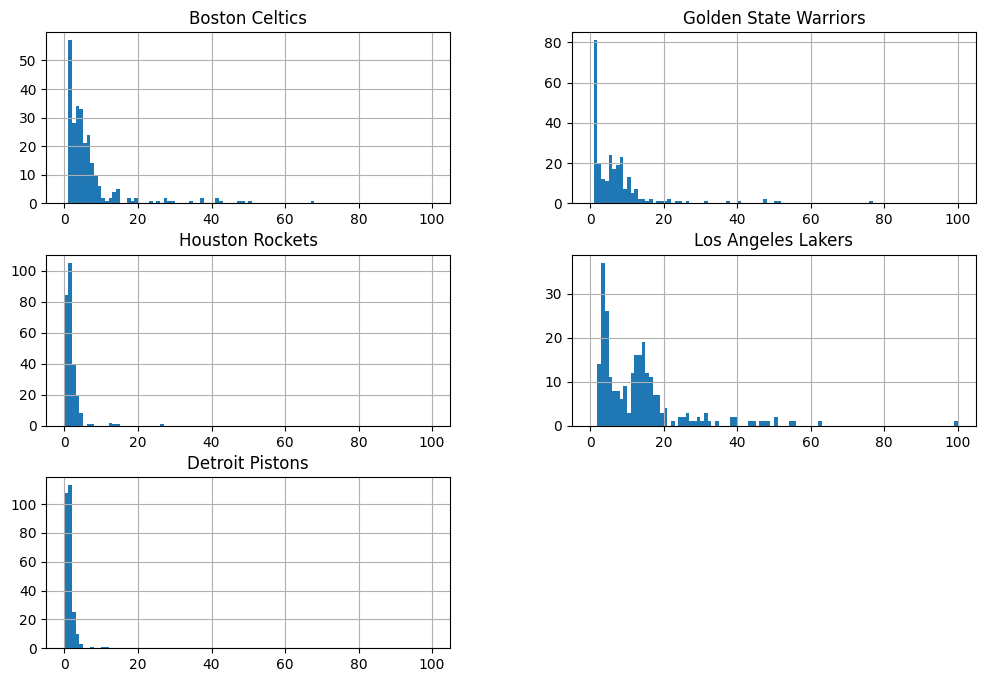

In [ ]:
# visualize the distribution of public interest
cols_to_keep = list(selected_teams_df['teamFullName'])
tt_df[cols_to_keep].hist(bins=np.arange(0,101,1), figsize=(12,8))

,Boston Celtics,Golden State Warriors,Houston Rockets,Los Angeles Lakers,Detroit Pistons
count,262.00,262.00,262.00,262.00,262.00
mean,6.48,6.58,1.38,12.79,0.89
std,9.15,8.89,2.38,12.10,1.26
min,1.00,1.00,0.00,2.00,0.00
25%,2.00,1.00,0.00,4.00,0.00
50%,4.00,5.00,1.00,11.00,1.00
75%,6.00,8.00,2.00,15.00,1.00
max,67.00,76.00,26.00,100.00,11.00


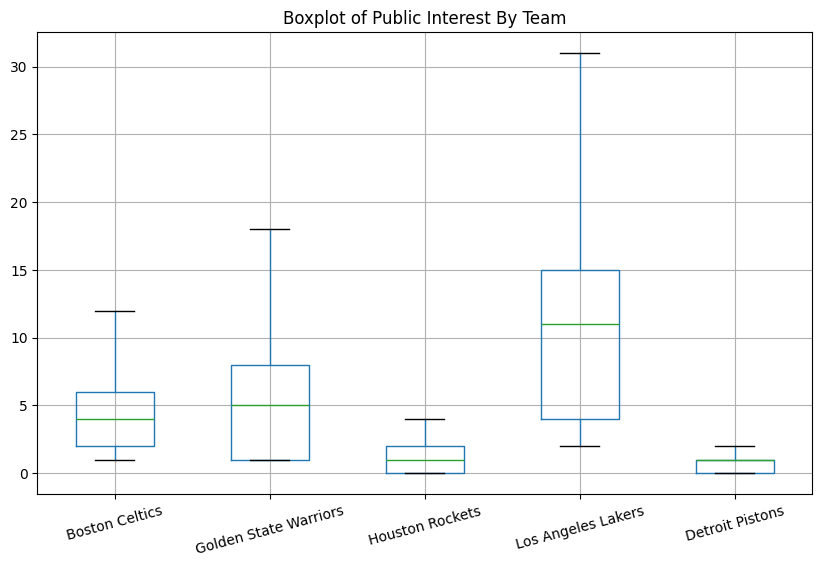

In [ ]:
# look at data summary for public interest for each team
tt_df[cols_to_keep].boxplot(rot=15,  showfliers=False, figsize=(10,6))
plt.title('Boxplot of Public Interest By Team')
tt_desc_df = np.round(tt_df[cols_to_keep].describe(), decimals=2)
tt_desc_df

In [ ]:
def get_public_interest_score(game_date, team_name):
    # tt_df is a cleaned version of team_trends_df with months 7, 8, 9 excluded
    for i, dt in enumerate(tt_df.date):
        within_7_days = abs(dt - game_date) < timedelta(days=7)
        if (dt <= game_date) & (within_7_days):
            team_full_name = selected_teams_df[selected_teams_df.teamNickname==team_name].teamFullName
            return float(tt_df.loc[i, team_full_name].values[0])

gameDate = '2024-03-24'
gameDate = datetime.strptime(gameDate, "%Y-%m-%d")
get_public_interest_score(gameDate, 'Celtics')

7.0

In [ ]:
def set_team_metrics_and_public_interest(team_name):
    '''
    team_name should be in the abbreviated team format of 'Celtics' or 'Warriors' etc
    '''
    df = nba_df.copy()
    # filter for games that team played in
    df = df[(df.homeTeam_teamName==team_name) | (df.awayTeam_teamName==team_name)]
    team_full_name = selected_teams_df[selected_teams_df.teamNickname==team_name].teamFullName
    # tt_desc_df is summary statistics for team_trends_df public interest scores
    st_dev = float(tt_desc_df.loc['std', team_full_name].values[0])
    mean = float(tt_desc_df.loc['mean', team_full_name].values[0])
    set_gameIds = set(df.gameId)
    results = []
    # iterate over each game and engineer some features
    for game_id in set_gameIds:
        game_s = df[df.gameId == game_id].iloc[0]
        is_away = game_s.awayTeam_teamName == team_name
        is_home = game_s.homeTeam_teamName == team_name
        # determine if team won game and points margin
        if is_away:
            points_margin = game_s.awayTeam_score - game_s.homeTeam_score
            if game_s.awayTeam_score > game_s.homeTeam_score:
                did_win = 1
            else:
                did_win = 0
        else: # is_home == True
            points_margin = game_s.homeTeam_score - game_s.awayTeam_score
            if game_s.homeTeam_score > game_s.awayTeam_score:
                did_win = 1
            else:
                did_win = 0

        # normalize public interest based on standard deviations from the mean
        pub_interest = get_public_interest_score(game_s.gameDate, team_name)
        std_from_mean = (pub_interest - mean) / st_dev

        obj = {
            'gameDate': game_s.gameDate,
            'teamName': team_name,
            'didWin': did_win,
            'stdFromMean': std_from_mean,
            'publicInterest': pub_interest,
            'pointsMargin': points_margin,
        }
        results.append(obj)

    return pd.DataFrame(results).set_index('gameDate').sort_index()

set_team_metrics_and_public_interest('Celtics')

,teamName,didWin,stdFromMean,publicInterest,pointsMargin
gameDate,,,,,
2022-10-18,Celtics,1,-0.052459,6.0,9.0
2022-10-21,Celtics,1,-0.052459,6.0,7.0
2022-10-22,Celtics,1,-0.052459,6.0,6.0
2022-10-24,Celtics,0,-0.161749,5.0,-18.0
2022-10-28,Celtics,0,-0.161749,5.0,-9.0
...,...,...,...,...,...
2025-04-06,Celtics,1,0.056831,7.0,34.0
2025-04-08,Celtics,1,0.056831,7.0,2.0
2025-04-09,Celtics,0,0.056831,7.0,-20.0


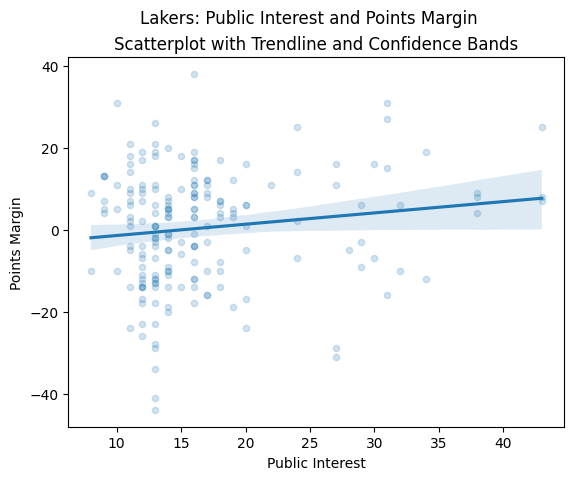

In [ ]:
def show_scatterplot_with_trendline(df, team_name):
    sns.regplot(data=df, x='publicInterest', y='pointsMargin', logistic=False,
        scatter_kws={'alpha': 0.2, 's': 20}#, x_jitter=0.05, y_jitter=0.05
    )
    plt.suptitle(f"{team_name}: Public Interest and Points Margin")
    plt.title("Scatterplot with Trendline and Confidence Bands")
    plt.xlabel("Public Interest")
    plt.ylabel("Points Margin")
    plt.show()

team_name = 'Lakers'
temp = set_team_metrics_and_public_interest(team_name)
show_scatterplot_with_trendline(temp, team_name)

In [ ]:
def plot_public_interest_and_win_pct(team_name):
    df = set_team_metrics_and_public_interest(team_name)
    show_scatterplot_with_trendline(df, team_name)

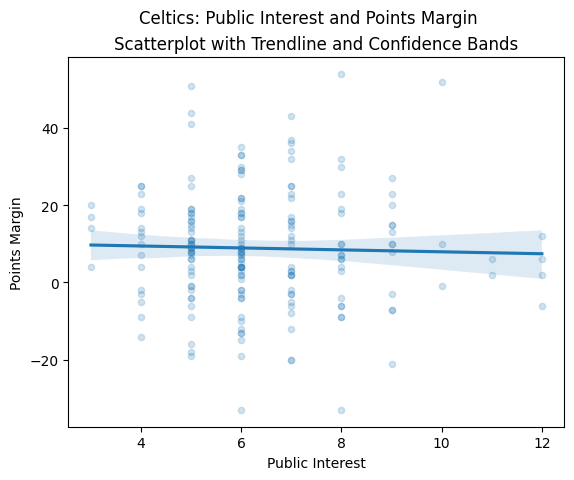

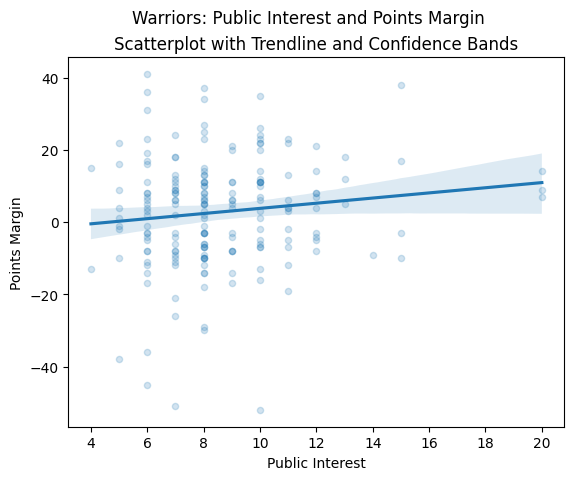

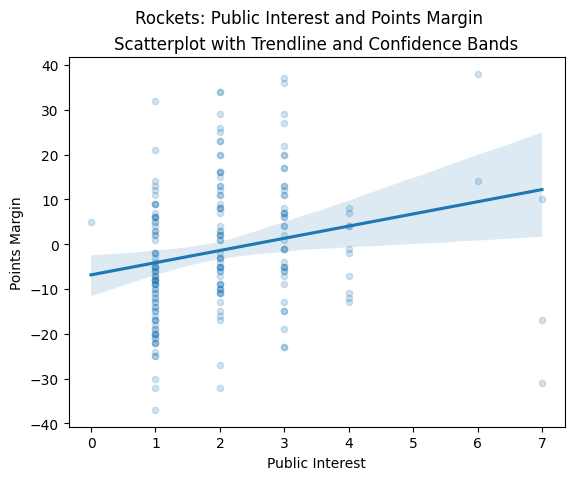

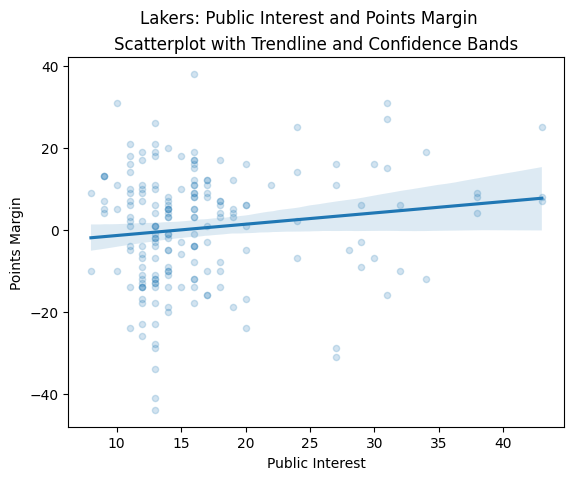

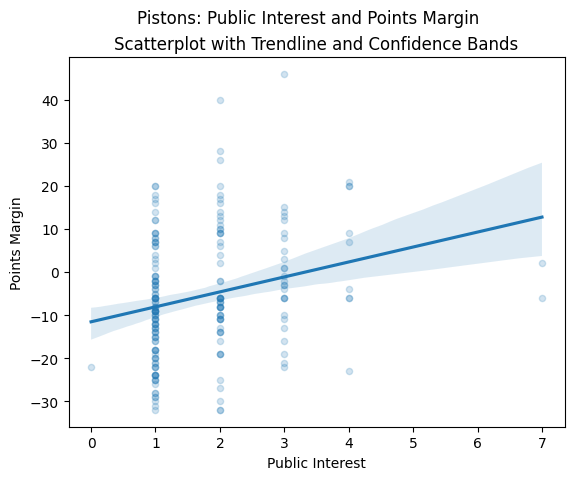

In [ ]:
for nick_name in selected_teams_abbr:
    plot_public_interest_and_win_pct(nick_name)

In [ ]:
# Team Score: score spread (+ is won, - is lost, range points spread) - may need to aggregate/avg if there are multiple games in a week?
# win/loss column 1 or 0
# start date = season start or last game date 1/1
# end date is next game date 1/5
# days inbetween games 4
# GTrends 1/1-1/5 or week of 1/1
# GTrends: avg/min/max/stddev of interest
# GTrends:

df.corr()

## Are underperforming high-salary teams more sensitive to external pressure?

In [ ]:
# calc win/loss streak by team
# sum total salary, grouped by team across all players by game

In [ ]:
nba_salary_df#.groupby(['seasonYear', 'gameId', 'teamName'])

,seasonYear,SEASON_TYPE,gameDate,gameId,gameCode,gameStatus,gameStatusText,gameSequence,gameDateTimeUTC,isNeutral,arenaCity,homeTeam_teamId,homeTeam_teamName,homeTeam_teamCity,homeTeam_teamTricode,homeTeam_seed,homeTeam_wins,homeTeam_losses,homeTeam_score,awayTeam_teamId,awayTeam_teamName,awayTeam_teamCity,awayTeam_teamTricode,awayTeam_seed,awayTeam_wins,awayTeam_losses,awayTeam_score,teamId,teamName,homeGameAdvantage,teamAbbreviation,teamNickname,teamCity,teamState,PLAYER_ID,PLAYER_NAME,NICKNAME,SEASON_AGE,GP,SEASON_W,SEASON_L,SEASON_W_PCT,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,AVAILABLE_FLAG,MIN_SEC,gameWeek,seasonWeek,PLAYER_NAME_CLEAN,salary
0,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000001143,Al Horford,Al,37.0,63,44,19,0.698,BOS vs. PHI,W,23.100000,2.0,7.0,0.286,2.0,5.0,0.40,0.0,0.0,0.000,1.0,4.0,5.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,8.0,13.5,0.0,0.0,14.0,1.0,1.0,1.0,1.0,59.0,42.0,30.0,51.0,25.0,25.0,34.0,12.0,13.0,12.0,18.0,34.0,35.0,51.0,28.0,27.0,37.0,1.0,56.0,25.0,43.0,24.0,59.0,8.0,1.0,59.0,1.0,23:06,2022-10-23,1,Al Horford,28097632.0
1,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000003935,Marcus Smart,Marcus,29.0,61,43,18,0.705,BOS vs. PHI,W,36.086667,3.0,8.0,0.375,1.0,4.0,0.25,7.0,8.0,0.875,1.0,2.0,3.0,7.0,1.0,1.0,0.0,0.0,3.0,7.0,14.0,0.0,30.1,0.0,0.0,27.0,1.0,1.0,1.0,1.0,15.0,39.0,39.0,41.0,38.0,38.0,38.0,1.0,1.0,13.0,12.0,29.0,26.0,21.0,42.0,31.0,20.0,1.0,27.0,2.0,19.0,33.0,24.0,7.0,1.0,30.0,1.0,36:05,2022-10-23,1,Marcus Smart,18244526.0
2,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000001933,Blake Griffin,Blake,34.0,41,27,14,0.659,BOS vs. PHI,W,8.285000,0.0,2.0,0.000,0.0,1.0,0.00,1.0,2.0,0.500,2.0,3.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,-5.0,8.5,0.0,0.0,7.0,1.0,1.0,1.0,1.0,29.0,27.0,21.0,27.0,16.0,19.0,16.0,6.0,6.0,6.0,7.0,11.0,10.0,14.0,18.0,14.0,10.0,1.0,30.0,13.0,27.0,35.0,26.0,1.0,1.0,26.0,1.0,8:17,2022-10-23,1,Blake Griffin,3081038.0
3,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000016281,Derrick White,Derrick,28.0,82,57,25,0.695,BOS vs. PHI,W,24.040000,1.0,3.0,0.333,0.0,1.0,0.00,0.0,1.0,0.000,1.0,2.0,3.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,2.0,9.0,13.6,0.0,0.0,11.0,1.0,1.0,1.0,1.0,64.0,73.0,79.0,60.0,67.0,82.0,67.0,59.0,53.0,59.0,10.0,47.0,39.0,26.0,25.0,12.0,50.0,56.0,28.0,12.0,80.0,27.0,73.0,8.0,1.0,74.0,1.0,24:02,2022-10-23,1,Derrick White,18176365.0
4,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000003943,Noah Vonleh,Noah,27.0,23,

## Does volatility to external pressures lessen with player age?

In [ ]:
# First let's create metrics for shots made and attempted using Field Goals, 3-pt FGs, and Free Throws.
nba_df['SHOT_M'] = nba_df['FGM'] + nba_df['FG3M'] + nba_df['FTM']
nba_df['SHOT_A'] = nba_df['FGA'] + nba_df['FG3A'] + nba_df['FTA']

nba_df

,seasonYear,SEASON_TYPE,gameDate,gameId,gameCode,gameStatus,gameStatusText,gameSequence,gameDateTimeUTC,isNeutral,arenaCity,homeTeam_teamId,homeTeam_teamName,homeTeam_teamCity,homeTeam_teamTricode,homeTeam_seed,homeTeam_wins,homeTeam_losses,homeTeam_score,awayTeam_teamId,awayTeam_teamName,awayTeam_teamCity,awayTeam_teamTricode,awayTeam_seed,awayTeam_wins,awayTeam_losses,awayTeam_score,teamId,teamName,homeGameAdvantage,teamAbbreviation,teamNickname,teamCity,teamState,PLAYER_ID,PLAYER_NAME,NICKNAME,SEASON_AGE,GP,SEASON_W,SEASON_L,SEASON_W_PCT,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,AVAILABLE_FLAG,MIN_SEC,gameWeek,seasonWeek,PLAYER_NAME_CLEAN,SHOT_M,SHOT_A,AGE_GROUP
0,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000001143,Al Horford,Al,37.0,63,44,19,0.698,BOS vs. PHI,W,23.100000,2.0,7.0,0.286,2.0,5.0,0.40,0.0,0.0,0.000,1.0,4.0,5.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,8.0,13.5,0.0,0.0,14.0,1.0,1.0,1.0,1.0,59.0,42.0,30.0,51.0,25.0,25.0,34.0,12.0,13.0,12.0,18.0,34.0,35.0,51.0,28.0,27.0,37.0,1.0,56.0,25.0,43.0,24.0,59.0,8.0,1.0,59.0,1.0,23:06,2022-10-23,1,Al Horford,4.0,12.0,35+
1,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000003935,Marcus Smart,Marcus,29.0,61,43,18,0.705,BOS vs. PHI,W,36.086667,3.0,8.0,0.375,1.0,4.0,0.25,7.0,8.0,0.875,1.0,2.0,3.0,7.0,1.0,1.0,0.0,0.0,3.0,7.0,14.0,0.0,30.1,0.0,0.0,27.0,1.0,1.0,1.0,1.0,15.0,39.0,39.0,41.0,38.0,38.0,38.0,1.0,1.0,13.0,12.0,29.0,26.0,21.0,42.0,31.0,20.0,1.0,27.0,2.0,19.0,33.0,24.0,7.0,1.0,30.0,1.0,36:05,2022-10-23,1,Marcus Smart,11.0,20.0,25-30
2,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000001933,Blake Griffin,Blake,34.0,41,27,14,0.659,BOS vs. PHI,W,8.285000,0.0,2.0,0.000,0.0,1.0,0.00,1.0,2.0,0.500,2.0,3.0,5.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,-5.0,8.5,0.0,0.0,7.0,1.0,1.0,1.0,1.0,29.0,27.0,21.0,27.0,16.0,19.0,16.0,6.0,6.0,6.0,7.0,11.0,10.0,14.0,18.0,14.0,10.0,1.0,30.0,13.0,27.0,35.0,26.0,1.0,1.0,26.0,1.0,8:17,2022-10-23,1,Blake Griffin,1.0,5.0,30-35
3,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,0000016281,Derrick White,Derrick,28.0,82,57,25,0.695,BOS vs. PHI,W,24.040000,1.0,3.0,0.333,0.0,1.0,0.00,0.0,1.0,0.000,1.0,2.0,3.0,4.0,1.0,1.0,0.0,1.0,2.0,4.0,2.0,9.0,13.6,0.0,0.0,11.0,1.0,1.0,1.0,1.0,64.0,73.0,79.0,60.0,67.0,82.0,67.0,59.0,53.0,59.0,10.0,47.0,39.0,26.0,25.0,12.0,50.0,56.0,28.0,12.0,80.0,27.0,73.0,8.0,1.0,74.0,1.0,24:02,2022-10-23,1,Derrick White,1.0,5.0,25-30
4,2022-23,Regular Season,2022-10-18,0000002201,20221018/PHIBOS,3.0,Final,1.0,2022-10-18 23:30:00+00:00,False,Boston,0016612738,Celtics,Boston,BOS,0.0,1.0,0.0,126.0,0016612755,76ers,Philadelphia,PHI,0.0,0.0,1.0,117.0,0016612738,Boston Celtics,True,BOS,Celtics,Boston,Massachusetts,00000

In [ ]:
player_week_age_shots_df = nba_df.groupby(['seasonYear', 'teamName', 'PLAYER_NAME', 'seasonWeek', 'gameWeek']).agg({'SEASON_AGE':'max', 'SHOT_M':'sum', 'SHOT_A':'sum'}).reset_index()
player_week_age_shots_df['SHOT_PCT'] = player_week_age_shots_df['SHOT_M'] / player_week_age_shots_df['SHOT_A']
player_week_age_shots_df['AGE_GROUP'] = pd.cut(player_week_age_shots_df['SEASON_AGE'],bins=[18, 24, 30, 35, 50],labels=['<25', '25-30', '30-35', '35+'])
player_week_age_shots_df

,seasonYear,teamName,PLAYER_NAME,seasonWeek,gameWeek,SEASON_AGE,SHOT_M,SHOT_A,SHOT_PCT,AGE_GROUP
0,2022-23,Boston Celtics,Al Horford,1,2022-10-23,37.0,10.0,22.0,0.454545,35+
1,2022-23,Boston Celtics,Al Horford,2,2022-10-30,37.0,12.0,24.0,0.500000,35+
2,2022-23,Boston Celtics,Al Horford,3,2022-11-06,37.0,17.0,44.0,0.386364,35+
3,2022-23,Boston Celtics,Al Horford,4,2022-11-13,37.0,30.0,40.0,0.750000,35+
4,2022-23,Boston Celtics,Al Horford,5,2022-11-20,37.0,22.0,40.0,0.550000,35+
...,...,...,...,...,...,...,...,...,...,...
4615,2024-25,Los Angeles Lakers,Trey Jemison III,22,2025-03-23,25.0,2.0,3.0,0.666667,25-30
4616,2024-25,Los Angeles Lakers,Trey Jemison III,23,2025-03-30,25.0,0.0,0.0,NaN,25-30
4617,2024-25,Los Angeles Lakers,Trey Jemison III,24,2025-04-06,25.0,0.0,0.0,NaN,25-30
4618,2024-25,Los Angeles Lakers,Trey Jemison III,25,2025-04-13,25.0,2.0,2.0,1.000000,25-30


In [ ]:
player_weekly_age_trends_df = player_week_age_shots_df.merge(player_trends_df
                                                             , how='left'
                                                             , left_on=['seasonYear', 'teamName', 'gameWeek', 'PLAYER_NAME']
                                                             , right_on=['seasonYear', 'teamName', 'date', 'player']
                                                             )
player_weekly_age_trends_df.drop(columns=['date', 'player'], inplace=True)
player_weekly_age_trends_df

,seasonYear,teamName,PLAYER_NAME,seasonWeek,gameWeek,SEASON_AGE,SHOT_M,SHOT_A,SHOT_PCT,AGE_GROUP,interest,interest_delta,interest_pct_change,interest_sign
0,2022-23,Boston Celtics,Al Horford,1,2022-10-23,37.0,10.0,22.0,0.454545,35+,5.0,-3.0,-0.375000,-1.0
1,2022-23,Boston Celtics,Al Horford,2,2022-10-30,37.0,12.0,24.0,0.500000,35+,7.0,2.0,0.400000,1.0
2,2022-23,Boston Celtics,Al Horford,3,2022-11-06,37.0,17.0,44.0,0.386364,35+,5.0,-2.0,-0.285714,-1.0
3,2022-23,Boston Celtics,Al Horford,4,2022-11-13,37.0,30.0,40.0,0.750000,35+,6.0,1.0,0.200000,1.0
4,2022-23,Boston Celtics,Al Horford,5,2022-11-20,37.0,22.0,40.0,0.550000,35+,5.0,-1.0,-0.166667,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,2024-25,Los Angeles Lakers,Trey Jemison III,22,2025-03-23,25.0,2.0,3.0,0.666667,25-30,0.0,-17.0,-1.000000,-1.0
4616,2024-25,Los Angeles Lakers,Trey Jemison III,23,2025-03-30,25.0,0.0,0.0,NaN,25-30,0.0,0.0,NaN,0.0
4617,2024-25,Los Angeles Lakers,Trey Jemison III,24,2025-04-06,25.0,0.0,0.0,NaN,25-30,11.0,11.0,inf,1.0
4618,2024-25,Los Angeles Lakers,Trey Jemison III,25,2025-04-13,25.0,2.0,2.0,1.000000,25-30,15.0,4.0,0.363636,1.0


In [ ]:
filtered_df = player_weekly_age_trends_df[player_weekly_age_trends_df['SHOT_PCT'].notnull()]

volatility_df = filtered_df.groupby('SEASON_AGE').agg(
    shot_pct_mean=('SHOT_PCT', 'mean'),
    shot_pct_std=('SHOT_PCT', 'std'),
    count=('SHOT_PCT', 'count')
    ).reset_index()

volatility_df

,SEASON_AGE,shot_pct_mean,shot_pct_std,count
0,19.0,0.514523,0.154454,68
1,20.0,0.455125,0.228773,204
2,21.0,0.453965,0.194398,433
3,22.0,0.469544,0.165771,414
4,23.0,0.487135,0.186430,252
...,...,...,...,...
17,36.0,0.491822,0.067542,25
18,37.0,0.491757,0.115841,76
19,38.0,0.480506,0.147514,87
20,39.0,0.508400,0.127762,50


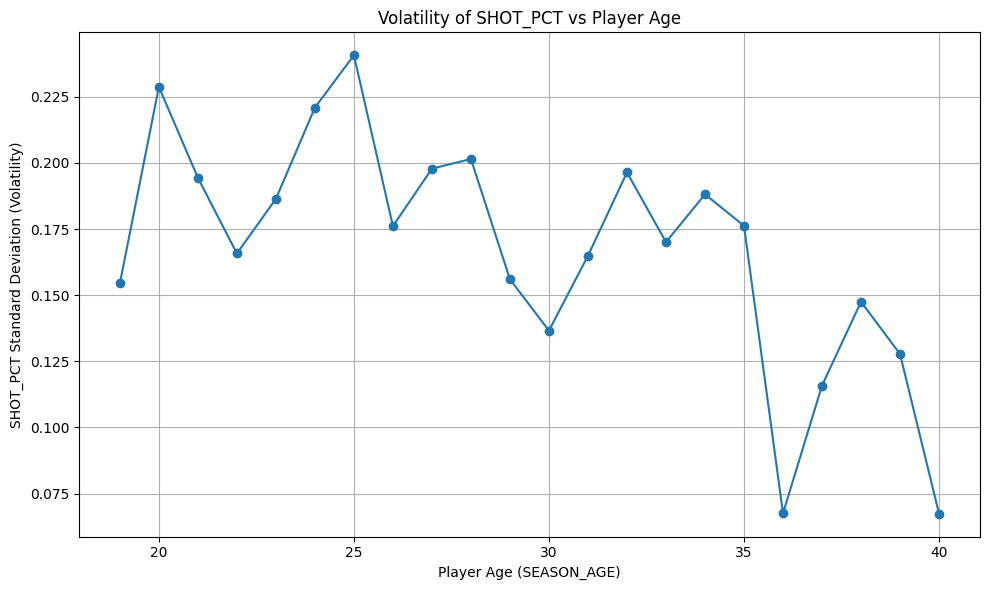

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(volatility_df['SEASON_AGE'], volatility_df['shot_pct_std'], marker='o')
plt.title('Volatility of SHOT_PCT vs Player Age')
plt.xlabel('Player Age (SEASON_AGE)')
plt.ylabel('SHOT_PCT Standard Deviation (Volatility)')
plt.grid(True)
plt.tight_layout()
plt.show()

*   Volatility decreases with age --> Older players are more consistent.

*   Great for understanding volatility and age on it's own, but how can we include in public interest/external pressures into the mix?



In [ ]:
player_summary_df = filtered_df.dropna(subset=['interest', 'SHOT_PCT', 'SEASON_AGE']
                                       ).groupby(['PLAYER_NAME', 'seasonYear', 'AGE_GROUP'], observed=True
                                                 ).agg(mean_interest=('interest', 'mean'),
                                                       std_interest=('interest', 'std'),
                                                       mean_shot_pct=('SHOT_PCT', 'mean'),
                                                       std_shot_pct=('SHOT_PCT', 'std'),
                                                       season_age=('SEASON_AGE', 'first')
                                                       ).reset_index()
player_summary_df

,PLAYER_NAME,seasonYear,AGE_GROUP,mean_interest,std_interest,mean_shot_pct,std_shot_pct,season_age
0,Aaron Holiday,2023-24,25-30,19.000000,17.688414,0.439411,0.158117,27.0
1,Aaron Holiday,2024-25,25-30,15.884615,23.404832,0.446142,0.170061,28.0
2,Al Horford,2022-23,35+,8.160000,3.036994,0.458062,0.127164,37.0
3,Al Horford,2023-24,35+,5.680000,2.212088,0.499574,0.108675,38.0
4,Al Horford,2024-25,35+,6.583333,3.855168,0.401477,0.115232,38.0
...,...,...,...,...,...,...,...,...
243,Usman Garuba,2022-23,<25,3.846154,19.611614,0.478515,0.250574,21.0
244,Wenyen Gabriel,2022-23,25-30,42.041667,18.123919,0.528613,0.192681,26.0
245,Xavier Tillman,2023-24,25-30,12.777778,6.887993,0.598280,0.284101,25.0
246,Xavier Tillman,2024-25,25-30,1.933333,3.594970,0.195979,0.218566,26.0


In [ ]:
grouped_corrs_summary = player_summary_df.groupby('AGE_GROUP').apply(lambda g: g['mean_interest'].corr(g['mean_shot_pct'])).reset_index(name='correlation')
grouped_corrs_summary

,AGE_GROUP,correlation
0,<25,0.113010
1,25-30,0.233733
2,30-35,0.250601
3,35+,-0.124212


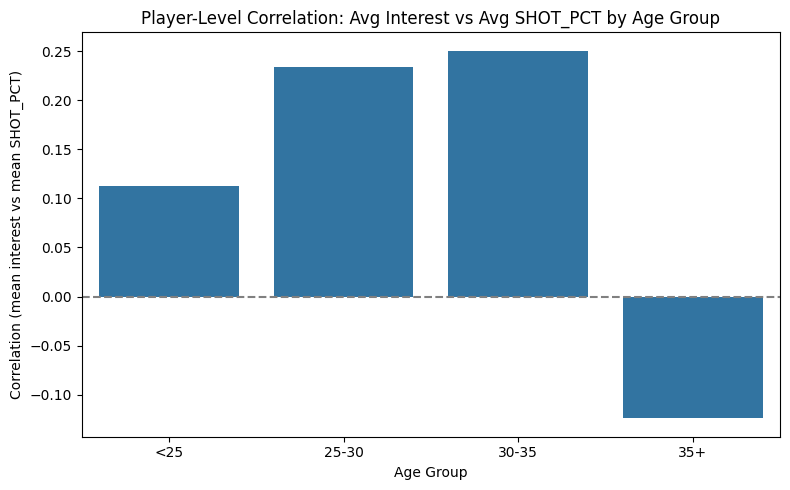

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x='AGE_GROUP', y='correlation', data=grouped_corrs_summary)
plt.title("Player-Level Correlation: Avg Interest vs Avg SHOT_PCT by Age Group")
plt.ylabel("Correlation (mean interest vs mean SHOT_PCT)")
plt.xlabel("Age Group")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


*   Younger and mid-career players with high public interest tend to shoot better, though not really by that much. Impact is minimal.
*   Older players (35+) have a mild negative trend, implying attention may not improve or even harm performance.

*   Maybe if you're an older player you're either really good like Lebron or you're struggling hard and you're getting bad public attention.





In [ ]:
# test to see if high interest weeks vs low have an impact on player performance/age
df_interest_binned = filtered_df.dropna(subset=['interest', 'SHOT_PCT', 'SEASON_AGE']).copy()

df_interest_binned['player_season'] = df_interest_binned['PLAYER_NAME'] + "_" + df_interest_binned['seasonYear']

median_interest_by_player_season = df_interest_binned.groupby('player_season')['interest'].transform('median')

df_interest_binned['interest_level'] = np.where(df_interest_binned['interest'] >= median_interest_by_player_season, 'High', 'Low')

df_interest_binned

,seasonYear,teamName,PLAYER_NAME,seasonWeek,gameWeek,SEASON_AGE,SHOT_M,SHOT_A,SHOT_PCT,AGE_GROUP,interest,interest_delta,interest_pct_change,interest_sign,player_season,interest_level
0,2022-23,Boston Celtics,Al Horford,1,2022-10-23,37.0,10.0,22.0,0.454545,35+,5.0,-3.0,-0.375000,-1.0,Al Horford_2022-23,Low
1,2022-23,Boston Celtics,Al Horford,2,2022-10-30,37.0,12.0,24.0,0.500000,35+,7.0,2.0,0.400000,1.0,Al Horford_2022-23,High
2,2022-23,Boston Celtics,Al Horford,3,2022-11-06,37.0,17.0,44.0,0.386364,35+,5.0,-2.0,-0.285714,-1.0,Al Horford_2022-23,Low
3,2022-23,Boston Celtics,Al Horford,4,2022-11-13,37.0,30.0,40.0,0.750000,35+,6.0,1.0,0.200000,1.0,Al Horford_2022-23,Low
4,2022-23,Boston Celtics,Al Horford,5,2022-11-20,37.0,22.0,40.0,0.550000,35+,5.0,-1.0,-0.166667,-1.0,Al Horford_2022-23,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613,2024-25,Los Angeles Lakers,Trey Jemison III,20,2025-03-09,25.0,8.0,13.0,0.615385,25-30,35.0,-65.0,-0.650000,-1.0,Trey Jemison III_2024-25,High
4614,2024-25,Los Angeles Lakers,Trey Jemison III,21,2025-03-16,25.0,1.0,3.0,0.333333,25-30,17.0,-18.0,-0.514286,-1.0,Trey Jemison III_2024-25,Low
4615,2024-25,Los Angeles Lakers,Trey Jemison III,22,2025-03-23,25.0,2.0,3.0,0.666667,25-30,0.0,-17.0,-1.000000,-1.0,Trey Jemison III_2024-25,Low
4618,2024-25,Los Angeles Lakers,Trey Jemison III,25,2025-04-13,25.0,2.0,2.0,1.000000,25-30,15.0,4.0,0.363636,1.0,Trey Jemison III_2024-25,Low


In [ ]:
binned_performance = df_interest_binned.groupby(['AGE_GROUP', 'interest_level'])['SHOT_PCT'].mean().reset_index()

binned_performance

,AGE_GROUP,interest_level,SHOT_PCT
0,<25,High,0.491410
1,<25,Low,0.464838
2,25-30,High,0.497002
3,25-30,Low,0.476638
4,30-35,High,0.480893
5,30-35,Low,0.476440
6,35+,High,0.498965
7,35+,Low,0.487687


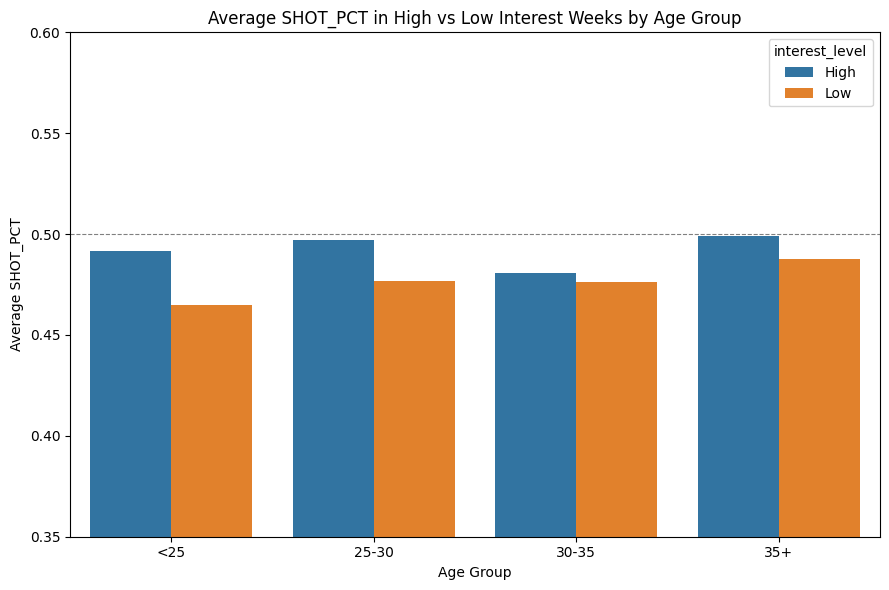

In [ ]:
plt.figure(figsize=(9, 6))
sns.barplot(data=binned_performance, x='AGE_GROUP', y='SHOT_PCT', hue='interest_level')
plt.title("Average SHOT_PCT in High vs Low Interest Weeks by Age Group")
plt.ylabel("Average SHOT_PCT")
plt.xlabel("Age Group")
plt.ylim(0.35, 0.6)
plt.axhline(0.5, color='gray', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

All groups perform slightly better in high-interest weeks.

*   The effect is strongest for younger players.
*   The performance gap shrinks with age, suggesting:
    *   Older players are less influenced by public pressure
    *   They maintain more stable performance regardless of attention

This supports our hypothesis that experience minimizes the volatility of external pressure.

In [ ]:
# Doing an ANOVA analysis to understand: Is the difference in SHOT_PCT statistically significant across interest levels, by age?
from scipy.stats import f_oneway

anova_results = []
for age_group in df_interest_binned['AGE_GROUP'].unique():
    subset = df_interest_binned[df_interest_binned['AGE_GROUP'] == age_group]
    high = subset[subset['interest_level'] == 'High']['SHOT_PCT']
    low = subset[subset['interest_level'] == 'Low']['SHOT_PCT']
    if len(high) > 10 and len(low) > 10:
        f_stat, p_val = f_oneway(high, low)
        anova_results.append({
            'AGE_GROUP': age_group,
            'F-statistic': f_stat,
            'p-value': p_val,
            'mean_high': high.mean(),
            'mean_low': low.mean()
        })

anova_df = pd.DataFrame(anova_results)
print(anova_df)

  AGE_GROUP  F-statistic   p-value  mean_high  mean_low
0       35+     0.507396  0.476909   0.498965  0.487687
1     30-35     0.091394  0.762517   0.480893  0.476440
2     25-30     4.385076  0.036410   0.497002  0.476638
3       <25     7.429751  0.006482   0.491410  0.464838


*   <25 p-value of .006: statistically significant. Younger players shoot significantly better in high-interest weeks
*   25-30 p-value of 0.036: statistically significant. significant but less impactful
*   30-35 p-value of 0.736: not statisically significant.
*   35+ p-value of 0.477: not statistically significant.

*   For younger players, public attention seems to impact performance positively.
*   For older players, differences between high and low attention weeks are not statistically significant — suggesting they’re less sensitive to external public interest pressure.

Q: Does shooting performance or sensitivity to public pressure (measured via Google Trends “interest”) lessen with player age?

Summary of Insights:

1. Performance Becomes More Stable with Age
    *   Older players show less week-to-week variation in shot percentage.
    *   Indicates greater performance consistency as players age.

    *   TLDR: Older players are more consistent shooters, regardless of external factors.

2. Public Attention (Interest) Positively Correlates with Performance - but Only for Younger Players
    *   From Player-Level Correlations:
        *   <30-year-olds had positive correlations between public interest and season performance.
        *   Players 35+ had slightly negative correlations — possibly due to different usage or psychological effects.
        *   TLDR: For younger and prime-age players, attention might be motivating. For older veterans, attention may not improve performance and surprisingly may even hinder it slightly.

3. Younger Players Shoot Better During High-Interest Weeks
    *   From Binned Avgs:
        *   All age groups improved slightly during high-interest weeks.
        *   Younger players (<30) had the largest boost — 2–2.6% gain in shot percentage.
        *   TLDR: Young players “rise to the occasion” more visibly when public attention is high.

4. Only Players Under 30 Show Statistically Significant Effects of Interest
    *   From ANOVA:
        *   SHOT_PCT differences between high and low-interest weeks were statistically significant for <25 and 25–30 age groups.
        *   No significant difference for players over 30. They've grown used to it?
        *   TLDR: The psychological or performance impact of external attention diminishes with age, likely due to experience, emotional regulation, or less media-driven usage.

Overall My Takeaway

Public pressure matters, but mostly for younger players.
They tend to perform slightly better when attention is high and may feed off the buzz.
As players age, performance stabilizes and becomes less reactive to changes in external attention.